# Image Classification with CIFAR-100 Dataset

### Project Overview

#### Introduction
This project aims to develop a deep learning model capable of accurately classifying images from the CIFAR-100 dataset. CIFAR-100 is a challenging dataset used in computer vision for benchmarking image recognition algorithms. It comprises 50,000 images distributed across 100 classes, with each class containing 500 images. The classes are grouped into 20 superclasses, each representing a higher-level concept (like vehicles or animals). Each image is small, colored, and sized at 32x32 pixels, making the task of classification non-trivial due to the low resolution.

#### Dataset Description
The CIFAR-100 dataset consists of:
- 50,000 training images
- 10,000 testing images
- 100 fine-grained classes (like various types of vehicles, flowers, insects, etc.)
- Images formatted in 32x32 pixels with 3 color channels (RGB)

#### Models and Methodology
Two primary approaches will be used to tackle the image classification challenge:

1. **Custom Convolutional Neural Network (CNN):**
   - A CNN model will be designed from scratch, tailored specifically to manage the size and complexity of CIFAR-100.
   - This model will feature multiple convolutional layers, pooling layers, and fully connected layers.
   - Activation functions such as ReLU will be utilized to introduce non-linearities into the model, and techniques like dropout and batch normalization may be applied to enhance training stability and model generalization.

2. **Pretrained Model Adaptation:**
   - A state-of-the-art pretrained model (such as ResNet, VGG, or MobileNet) will be utilized as a starting point, leveraging transfer learning to improve accuracy and training speed.
   - The output layer of the pretrained model will be modified to classify 100 classes specific to CIFAR-100, replacing the original classification layer which is typically suited to 1000 classes (as per ImageNet standards).
   - Fine-tuning and feature extraction techniques will be used to adapt the pretrained model to the new dataset.

#### Data Analysis and Preprocessing
- **Data Visualization:** Early stages will involve visualizing images and their corresponding labels to understand the dataset’s structure and class distribution.
- **Data Augmentation:** Techniques such as rotation, translation, scaling, and horizontal flipping will be applied to artificially expand the training dataset, which helps prevent overfitting and promotes model robustness.
- **Normalization:** Pixel values will be normalized to have a mean of 0 and a standard deviation of 1, aligning with common practice for neural network inputs.

#### Hyperparameter Tuning and Model Optimization
- **Hyperparameter Optimization:** Key hyperparameters like learning rate, batch size, and number of epochs will be tuned using strategies such as grid search or random search, possibly supplemented by more sophisticated methods like Bayesian optimization.
- **Regularization Techniques:** L2 regularization, dropout, and possibly early stopping will be employed to reduce overfitting and improve model performance on unseen data.
- **Learning Rate Schedulers:** Dynamic adjustment of the learning rate during training will be considered to optimize the convergence rate and potentially improve final accuracy.

#### Expected Challenges and Solutions
- Due to the low resolution and high variability within CIFAR-100, model accuracy might initially be limited. Enhanced data preprocessing and sophisticated model architectures will be crucial.
- Overfitting could be a significant issue given the deep architectures necessary for this task. Regularization, data augmentation, and proper hyperparameter tuning will be central to mitigating this.

This project will provide a comprehensive understanding of applying deep learning, particularly CNNs, to a complex, real-world image classification problem. Through the development of a custom CNN and adaptation of a pretrained model, combined with rigorous data preprocessing and model optimization techniques, we aim to achieve high accuracy in classifying images from the CIFAR-100 dataset. This endeavor will also enhance our understanding of the practical challenges and solutions in deploying deep learning models in the field of computer vision.

In [4]:
import time
import json
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image
import optuna
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Exploratory Data Analysis (EDA) — Inspection, Visualization, and Cleaning

#### Introduction to EDA for CIFAR-100
Exploratory Data Analysis (EDA) is an essential preliminary step in comprehending the CIFAR-100 dataset, setting the stage for the development of effective convolutional neural networks. Through EDA, we gain insights into the structure, distribution, and inherent challenges of the data, guiding our preprocessing and modeling strategies.

#### Data Cleaning, Normalization, and Loading
The first step in our EDA is to normalize the data to ensure it is standardized. This involves adjusting the pixel values so that the input features (image pixel intensities) have similar data distributions. This normalization aids in stabilizing the neural network's training process by keeping the data within a range that prevents the gradients from becoming too large or too small.

After normalization, the data is loaded into a structured format that supports efficient access during model training. This involves organizing the images and their corresponding labels into batches, which allows the model to update its weights more smoothly and consistently.

#### Counting and Inspecting Data
It's crucial to verify the size of our training and testing datasets and count the number of classes. Knowing the exact number of images available for each class helps in understanding the dataset's balance. Imbalanced classes can lead to biased models that perform well on over-represented classes but poorly on under-represented ones.

#### Visualization of Samples
Visualizing a subset of images along with their labels is an effective way to get a tangible sense of what the dataset contains. This visualization helps in identifying if the images are labeled correctly and provides insights into the potential difficulties that the model might face due to the low resolution or similar-looking classes.

#### Distribution of Classes
Plotting the distribution of the number of images across different classes reveals any imbalance in the dataset. A bar graph can be employed to visually assess how evenly distributed the images are among the 100 classes. Identifying any discrepancies in distribution early on can guide necessary adjustments, such as data augmentation strategies or weighted loss functions during training.

#### Analyzing Color Intensity Distributions
Examining the RGB intensity distribution of the images can uncover insights into the dataset’s color composition. This analysis involves plotting the average intensity of red, green, and blue components across the dataset. Understanding these distributions is useful for detecting any color biases or anomalies in the dataset.

#### Overall Pixel Intensity Examination
Beyond RGB intensities, analyzing the overall pixel intensity distribution across all images helps in understanding the general brightness and contrast characteristics of the dataset. This analysis can inform decisions regarding image preprocessing steps such as contrast normalization or brightness adjustment, which may be necessary to improve model performance.

Through these EDA steps, we prepare the groundwork for more effective and informed model building and tuning, ultimately leading to better performance and robustness in image classification tasks.

In [5]:
# Transform the data to tensor and normalize it
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and load the training and test set
fullset = torchvision.datasets.CIFAR100(root='./', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./', train=False,
                                       download=True, transform=transform)

# Create data loaders
fullloader = torch.utils.data.DataLoader(fullset, batch_size=32,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

100%|██████████| 169001437/169001437 [00:11<00:00, 15037167.90it/s]


Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified


In [6]:
classes = fullset.classes
num_classes = len(classes)
num_training_images = len(fullset)
num_test_images = len(testset)

print(f'Total number of classes: {num_classes}')
print(f'Total number of training images: {num_training_images}')
print(f'Total number of testing images: {num_test_images}')

Total number of classes: 100
Total number of training images: 50000
Total number of testing images: 10000


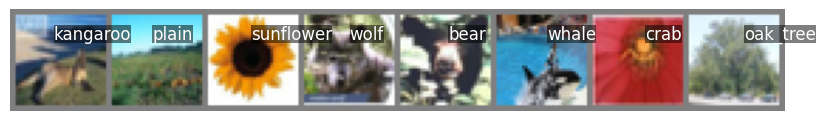

In [7]:
# Function to show images and labels
def imshow(img, labels):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))  # Set the figure size to better fit the number of images
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Hide the axis

    # Add labels within the plot
    num_images = len(labels)
    x_positions = np.linspace(start=15, stop=img.shape[2] - 15, num=num_images)
    y_position = 5
    for i, (x, label) in enumerate(zip(x_positions, labels)):
        plt.text(x, y_position, classes[label], color='white', fontsize=12, verticalalignment='top',
                 bbox=dict(facecolor='black', alpha=0.5, pad=0, edgecolor='none'))
    plt.show()

# Function to get and display multiple images
def show_images(dataset, num_images=4):
    # Create a new DataLoader with the specified batch size
    temp_loader = DataLoader(dataset, batch_size=num_images, shuffle=True, num_workers=2)

    # Get some random training images
    dataiter = iter(temp_loader)
    images, labels = next(dataiter)

    # Make a grid from batch
    img_grid = torchvision.utils.make_grid(images)
    imshow(img_grid, labels)

# Example usage: Display 6 images
show_images(fullset, 8)

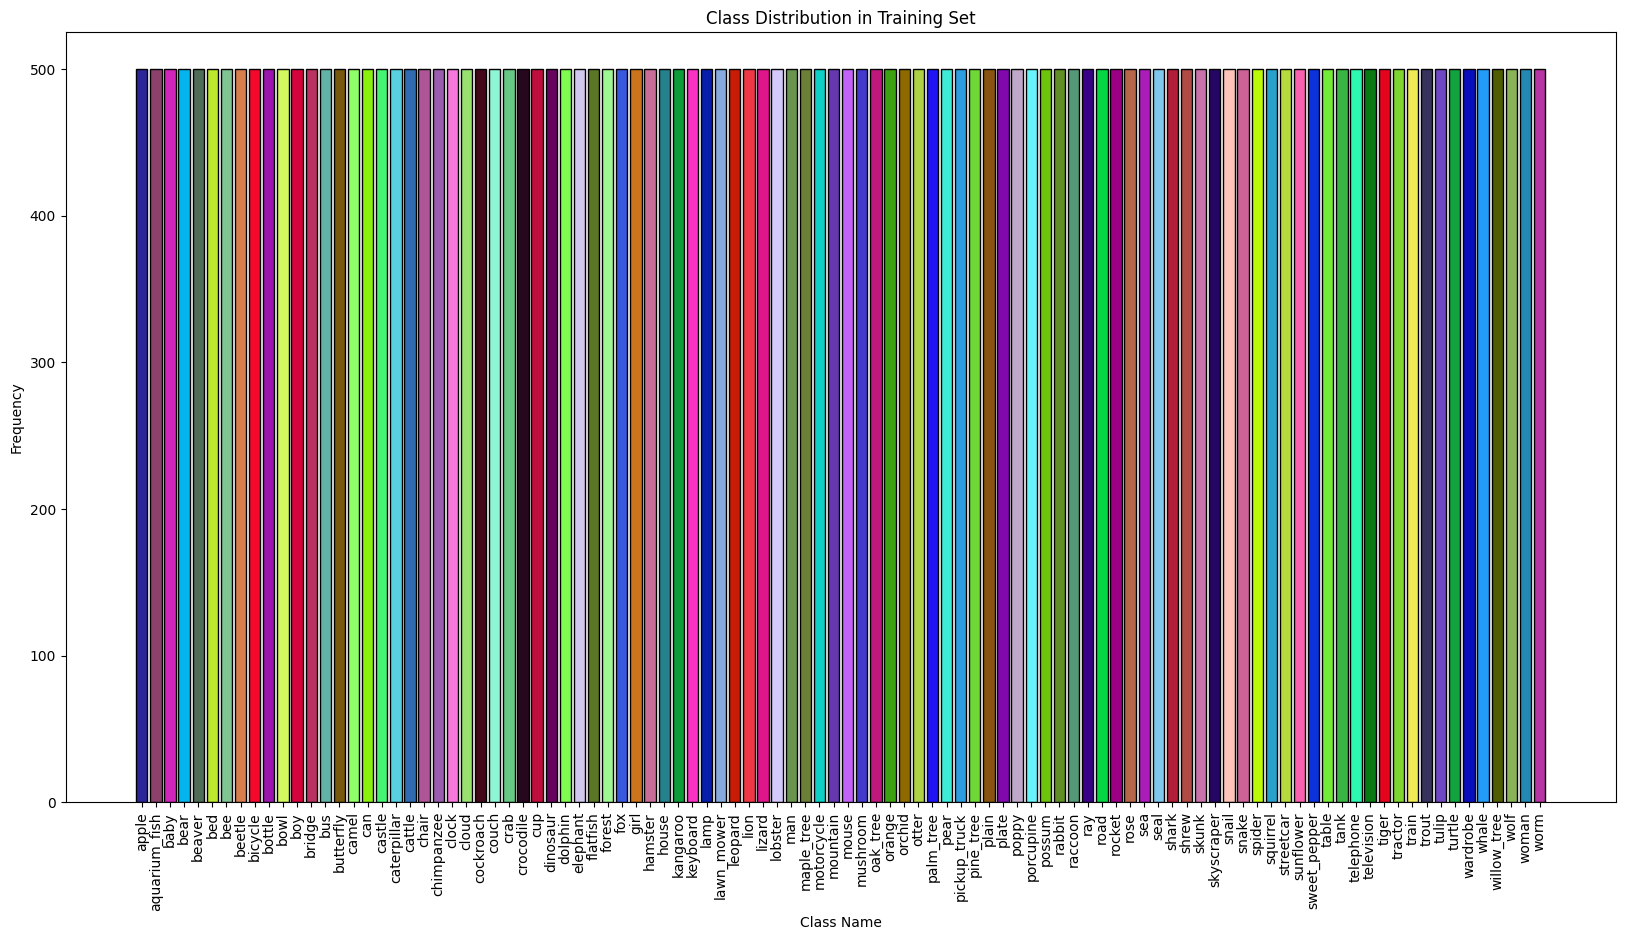

In [30]:
# Collect all labels from the DataLoader
all_labels = []
for _, labels in fullloader:
    all_labels.extend(labels.numpy().tolist())  # Convert labels to a list and append

# Calculate histogram data
hist, bin_edges = np.histogram(all_labels, bins=np.arange(num_classes + 1))

# Generate a random color array
colors = np.random.rand(num_classes, 3)

# Plot the histogram as a bar chart
plt.figure(figsize=(20, 10))  # Increased figure size for better readability
plt.bar(range(num_classes), hist, color=colors, edgecolor='black')
plt.xlabel('Class Name')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Set')
plt.xticks(ticks=range(num_classes), labels=classes, rotation=90)  # Set x-ticks to class names
plt.show()

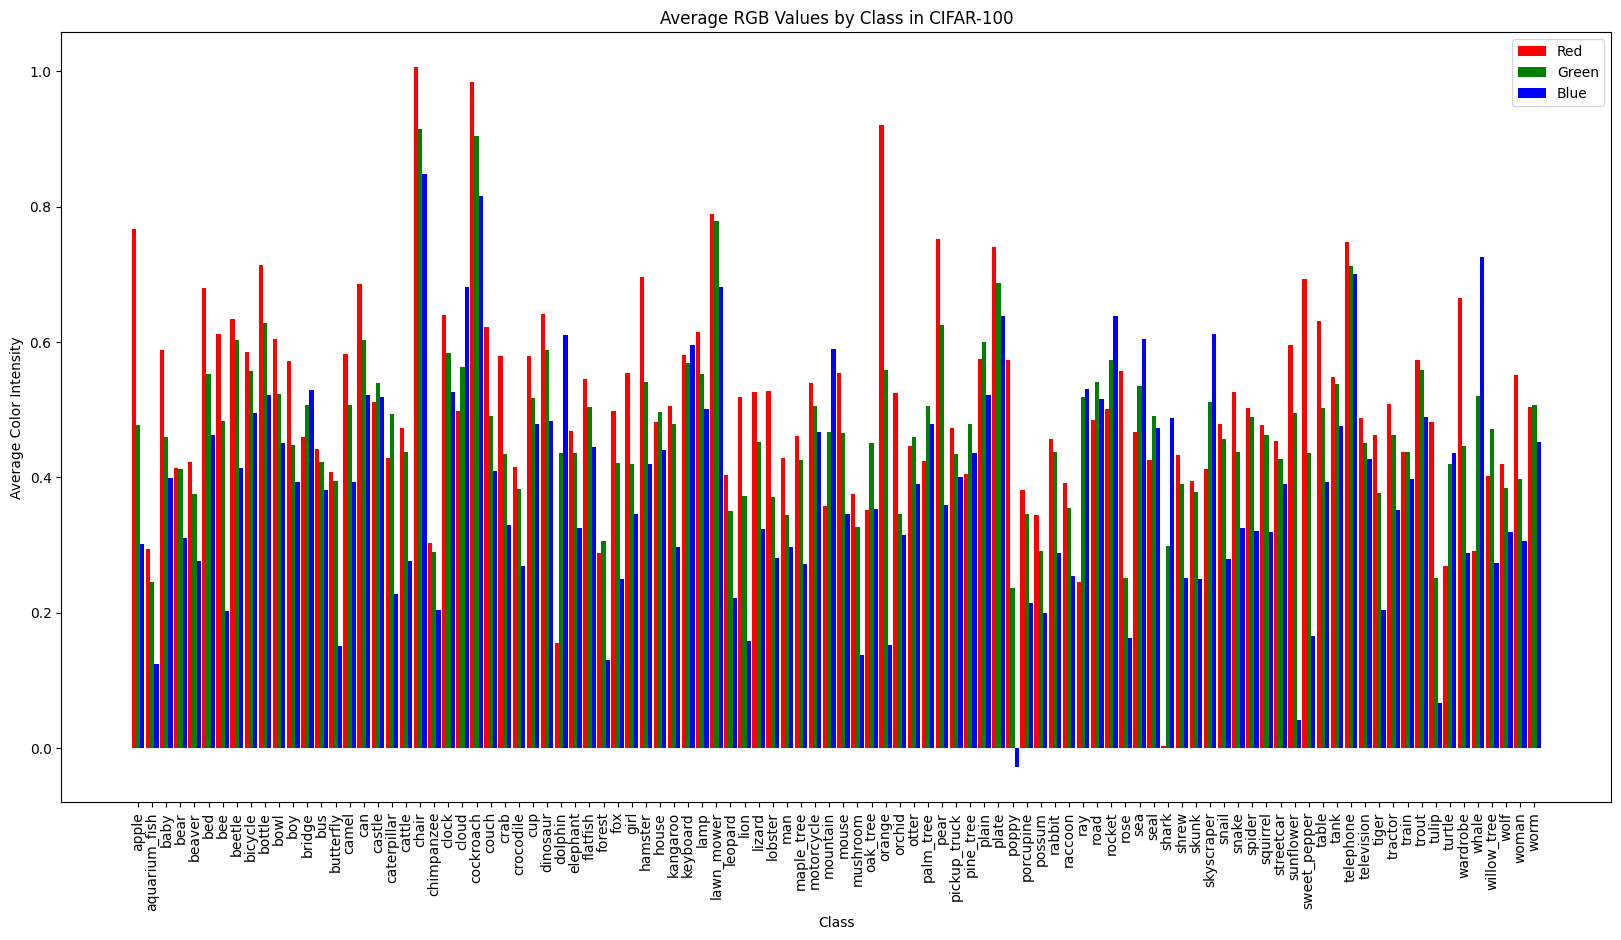

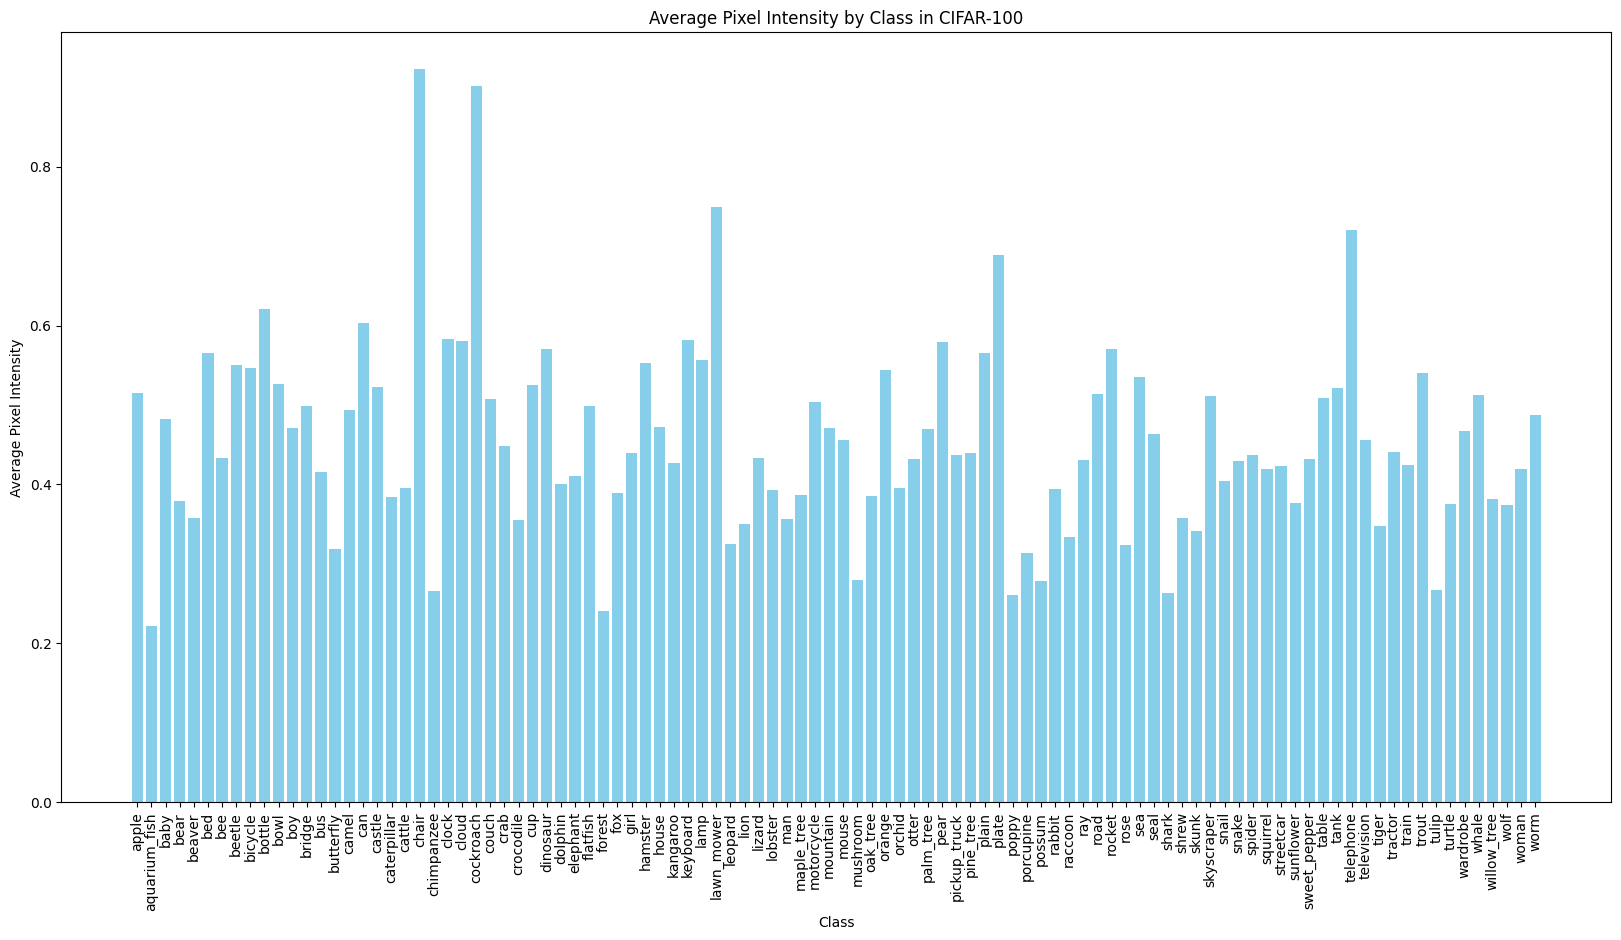

In [44]:
# Initialize storage for RGB values per class
rgb_values = defaultdict(lambda: {'r': [], 'g': [], 'b': []})
class_counts = defaultdict(int)

# Initialize storage for pixel intensities per class
intensity_values = defaultdict(list)

# Compute the mean RGB values for each image and accumulate
for images, labels in fullloader:
    for i in range(images.size(0)):  # Loop through each image in the batch
        label = labels[i].item()  # Handle each label

        r = images[i, 0, :, :].mean().item() + 0.5  # unnormalize and calculate average for R channel
        g = images[i, 1, :, :].mean().item() + 0.5  # unnormalize and calculate average for G channel
        b = images[i, 2, :, :].mean().item() + 0.5  # unnormalize and calculate average for B channel
        rgb_values[label]['r'].append(r)
        rgb_values[label]['g'].append(g)
        rgb_values[label]['b'].append(b)
        
        # Calculate the average intensity across all pixels and channels
        intensity = images[i].mean().item() + 0.5  # unnormalize and calculate average for all channels
        intensity_values[label].append(intensity)

# Calculate the average RGB values per class
average_rgb_per_class = {cls: {color: np.mean(values[color]) for color in ('r', 'g', 'b')} for cls, values in rgb_values.items()}

# Calculate the average intensity per class
average_intensity_per_class = {cls: np.mean(intensities) for cls, intensities in intensity_values.items()}                                       

# Data for plotting
classes = fullloader.classes
class_indices = range(len(classes))

r_means = [average_rgb_per_class[i]['r'] for i in class_indices]
g_means = [average_rgb_per_class[i]['g'] for i in class_indices]
b_means = [average_rgb_per_class[i]['b'] for i in class_indices]

intensities = [average_intensity_per_class[i] for i in class_indices]

# Plotting the RGB distributions
fig, ax = plt.subplots(figsize=(20, 10))
bar_width = 0.3
rects1 = ax.bar(class_indices, r_means, bar_width, label='Red', color='red')
rects2 = ax.bar([x + bar_width for x in class_indices], g_means, bar_width, label='Green', color='green')
rects3 = ax.bar([x + 2 * bar_width for x in class_indices], b_means, bar_width, label='Blue', color='blue')
ax.set_xlabel('Class')
ax.set_ylabel('Average Color Intensity')
ax.set_title('Average RGB Values by Class in CIFAR-100')
ax.set_xticks([x + bar_width for x in class_indices])
ax.set_xticklabels(classes, rotation=90)
ax.legend()
plt.show()
                                       
# Plotting the intensities
plt.figure(figsize=(20, 10))
plt.bar(class_indices, intensities, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Average Pixel Intensity')
plt.title('Average Pixel Intensity by Class in CIFAR-100')
plt.xticks(ticks=class_indices, labels=classes, rotation=90)
plt.show()

### Model Architecture Summary

#### Overview
This section outlines the architectures of two neural network models tailored for image classification on the CIFAR-100 dataset, utilizing standard preprocessed data. The preprocessing includes normalizing the pixel intensities to enhance model performance and ensure consistent input data distribution.

#### SimpleCNN Architecture
The `SimpleCNN` model is a custom convolutional neural network designed to start from basic principles in learning feature representations from images. The architecture comprises three convolutional layers with increasing depth—from 32 filters in the first layer to 128 filters in the third. Each convolutional layer uses a 3x3 kernel with padding to preserve spatial dimensions, followed by ReLU activation for non-linearity and a max pooling layer to reduce spatial dimensions and enhance feature extraction.

Post convolutional layers, a dropout layer is introduced to mitigate overfitting by randomly dropping units (with a dropout rate of 0.25) during the training process. The network transitions to fully connected layers, where the first dense layer maps the flattened features from the convolutional layers to 512 nodes, followed by the final output layer which maps these nodes to 100 classes corresponding to CIFAR-100's categories.

#### PretrainedResNet Architecture
The `PretrainedResNet` leverages the robust and extensively validated ResNet-50 architecture, pre-trained on a larger and diverse dataset (ImageNet). This model is modified to suit the 100-class problem of CIFAR-100 by replacing the original fully connected layer with a new one that outputs 100 classes instead of 1000. Utilizing a pretrained model allows leveraging learned features which can significantly improve performance especially when fine-tuned for CIFAR-100.

In [9]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # Convolutional layer (3-input, 32-output, 3x3 kernel, padding 1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # Max pooling layer (2x2 pool size)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 4 * 4, 512) # Fully connected layer
        self.fc2 = nn.Linear(512, 100) # Output layer
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4) # Flatten the tensor for the fully connected layer
        x = self.dropout(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
# Load a pretrained ResNet and modify it for CIFAR-100
class PretrainedResNet(nn.Module):
    def __init__(self):
        super(PretrainedResNet, self).__init__()
        base_model = models.resnet50(weights=True) # Load a pretrained ResNet
        num_ftrs = base_model.fc.in_features
        base_model.fc = nn.Linear(num_ftrs, 100) # Replace the last FC layer for CIFAR-100

        self.base_model = base_model

    def forward(self, x):
        return self.base_model(x)

### Training, Validation, and Evaluation Process

#### Training and Validation Loop
The training and validation of both the `SimpleCNN` and `PretrainedResNet` models are conducted through an iterative process across multiple epochs. During each training epoch, the model learns by processing batches of images, calculating loss, and updating weights. Performance metrics such as loss and accuracy are computed to monitor progress and ensure effective learning.

Following training, the model undergoes validation using a separate dataset. This phase is crucial for evaluating the model's generalization capabilities and identifying any signs of overfitting. It involves computing the validation loss and accuracy without updating the model's weights.

#### Evaluation of Results
To thoroughly assess the training and validation results, a visual analysis is conducted using the function `plot_train_and_val_accuracies_losses`. This function generates three plots:
- **Training and Validation Accuracy**: Tracks how accurately the model predicts the class labels over the epochs for both training and validation datasets. It highlights convergence trends and discrepancies between training and validation accuracy, indicating potential overfitting.
- **Training and Validation Loss**: Observes the model's loss reduction over time, providing insights into the learning efficiency and stability of the model across epochs.
- **Time Per Epoch**: Analyzes the computational efficiency by plotting the duration of each training epoch, helping to identify any bottlenecks in the training process.

These visualizations serve as critical tools for evaluating the model's performance dynamics and are essential for iterative model tuning and improvement. By analyzing these plots, one can make informed decisions about adjustments to the learning process, such as tweaking hyperparameters, altering the model architecture, or adjusting the training regimen to optimize performance and efficiency.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def validate(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_correct = 0
    total = 0
    
    with torch.no_grad():  # No gradients needed
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / len(val_loader)
    accuracy = total_correct / total
    return avg_loss, accuracy

def train(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.to(device)
    train_accuracies, train_losses, val_accuracies, val_losses, epoch_times = [], [], [], [], []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0
        total_correct = 0
        total = 0
        
        start_time = time.time()  # Start time for the epoch
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        end_time = time.time()  # End time for the epoch
        epoch_duration = end_time - start_time  # Calculate duration
        epoch_times.append(epoch_duration)  # Store duration for each epoch
        
        train_accuracy = total_correct / total
        avg_train_loss = total_train_loss / len(train_loader)
        
        # Validation step
        avg_val_loss, val_accuracy = validate(model, val_loader, criterion)
        
        train_accuracies.append(train_accuracy)
        train_losses.append(avg_train_loss)
        val_accuracies.append(val_accuracy)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}: Duration: {epoch_duration:.2f}s, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return train_accuracies, train_losses, val_accuracies, val_losses, epoch_times

In [24]:
def plot_train_and_val_accuracies_losses(train_accuracies, train_losses, val_accuracies, val_losses, epoch_times):
    epochs = range(1, len(train_accuracies) + 1)

    # Create a figure and a set of subplots.
    fig, ax = plt.subplots(1, 3, figsize=(13, 4))  # Adjusted for 3 subplots

    # Plotting training and validation accuracies
    ax[0].plot(epochs, train_accuracies, 'b', label='Training Accuracy')
    ax[0].plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Plotting training and validation losses
    ax[1].plot(epochs, train_losses, 'b', label='Training Loss')
    ax[1].plot(epochs, val_losses, 'r', label='Validation Loss')
    ax[1].set_title('Training and Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    # Plotting time per epoch
    ax[2].plot(epochs, epoch_times, 'g', label='Epoch Time')
    ax[2].set_title('Time Per Epoch')
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('Time (seconds)')
    ax[2].legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

In [18]:
# Get the indices of all data points
indices = list(range(len(fullset)))

# Split indices into training and validation sets
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42, stratify=[fullset.targets[i] for i in indices])

train_subset = Subset(fullset, train_indices)
val_subset = Subset(fullset, val_indices)

trainloader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=4)
valloader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=4)

In [31]:
# Simple CNN Model, Loss, and Optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_accuracies, train_losses, val_accuracies, val_losses, epoch_times = train(model, trainloader, valloader, criterion, optimizer, epochs=50)

Epoch 1: Duration: 5.52s, Train Loss: 3.6929, Train Accuracy: 0.1381, Validation Loss: 3.2203, Validation Accuracy: 0.2082
Epoch 2: Duration: 5.64s, Train Loss: 2.9450, Train Accuracy: 0.2651, Validation Loss: 2.8077, Validation Accuracy: 0.2982
Epoch 3: Duration: 5.54s, Train Loss: 2.5898, Train Accuracy: 0.3391, Validation Loss: 2.6313, Validation Accuracy: 0.3339
Epoch 4: Duration: 5.52s, Train Loss: 2.3172, Train Accuracy: 0.3949, Validation Loss: 2.4804, Validation Accuracy: 0.3716
Epoch 5: Duration: 5.54s, Train Loss: 2.1034, Train Accuracy: 0.4409, Validation Loss: 2.3997, Validation Accuracy: 0.3926
Epoch 6: Duration: 6.06s, Train Loss: 1.9200, Train Accuracy: 0.4817, Validation Loss: 2.3546, Validation Accuracy: 0.4013
Epoch 7: Duration: 5.54s, Train Loss: 1.7514, Train Accuracy: 0.5179, Validation Loss: 2.3433, Validation Accuracy: 0.4109
Epoch 8: Duration: 5.54s, Train Loss: 1.5958, Train Accuracy: 0.5549, Validation Loss: 2.3418, Validation Accuracy: 0.4138
Epoch 9: Duratio

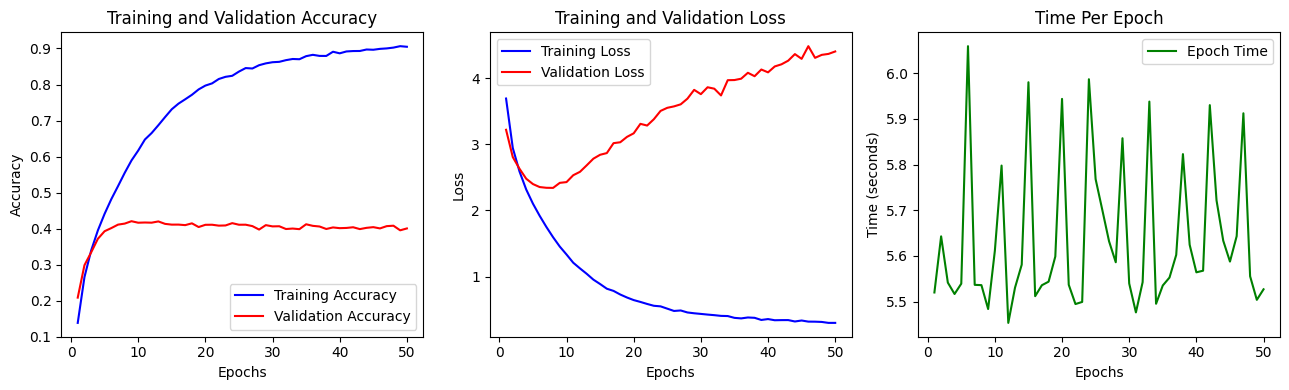

In [44]:
plot_train_and_val_accuracies_losses(train_accuracies, train_losses, val_accuracies, val_losses, epoch_times)

In [45]:
# ResNet Model, Loss, and Optimizer
model = PretrainedResNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_accuracies, train_losses, val_accuracies, val_losses, epoch_times = train(model, trainloader, valloader, criterion, optimizer, epochs=50)

Epoch 1: Duration: 31.21s, Train Loss: 2.7080, Train Accuracy: 0.3340, Validation Loss: 1.8772, Validation Accuracy: 0.4905
Epoch 2: Duration: 31.85s, Train Loss: 1.5695, Train Accuracy: 0.5630, Validation Loss: 1.6544, Validation Accuracy: 0.5439
Epoch 3: Duration: 31.61s, Train Loss: 1.0876, Train Accuracy: 0.6853, Validation Loss: 1.6273, Validation Accuracy: 0.5669
Epoch 4: Duration: 31.38s, Train Loss: 0.7592, Train Accuracy: 0.7731, Validation Loss: 1.6955, Validation Accuracy: 0.5638
Epoch 5: Duration: 31.87s, Train Loss: 0.5427, Train Accuracy: 0.8348, Validation Loss: 1.7943, Validation Accuracy: 0.5644
Epoch 6: Duration: 31.01s, Train Loss: 0.4007, Train Accuracy: 0.8767, Validation Loss: 1.8588, Validation Accuracy: 0.5786
Epoch 7: Duration: 31.16s, Train Loss: 0.3118, Train Accuracy: 0.9032, Validation Loss: 1.9617, Validation Accuracy: 0.5740
Epoch 8: Duration: 31.20s, Train Loss: 0.2697, Train Accuracy: 0.9146, Validation Loss: 2.0800, Validation Accuracy: 0.5699
Epoch 9:

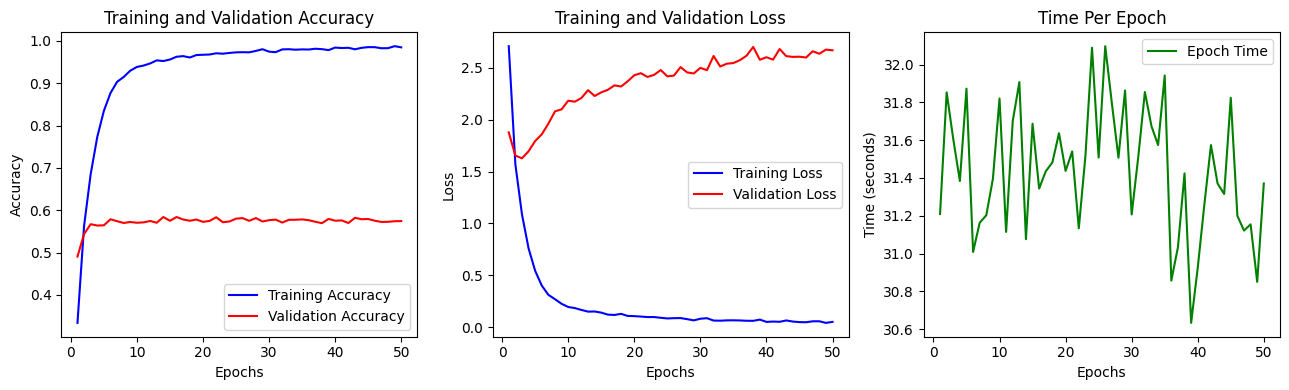

In [46]:
plot_train_and_val_accuracies_losses(train_accuracies, train_losses, val_accuracies, val_losses, epoch_times)

### Results Summary: SimpleCNN vs. PretrainedResNet

In a 50-epoch training, the SimpleCNN model demonstrated quick learning but plateaued to a validation accuracy around 40%, hinting at overfitting as training accuracy continued to climb. The model's training time per epoch was consistent, averaging just over 5.5 seconds.

The PretrainedResNet, starting with a higher base accuracy due to transfer learning, showed a better validation peak at approximately 58%. However, it also began to overfit, as indicated by rising validation loss, despite higher overall accuracies. It was more time-consuming, with epochs averaging 31 seconds.

Both models experienced overfitting, which suggests a need for regularization and potentially more sophisticated training schedules. The PretrainedResNet offered a balance between higher accuracy and increased computational demand, whereas the SimpleCNN was quicker but less accurate. These insights suggest potential for model refinement, possibly by employing additional strategies to combat overfitting and improve generalization to new data.

### Summary: Overfitting Reduction in GeneralizedCNN

The updated `GeneralizedCNN` model has been improved to address overfitting, a significant issue observed in the initial `SimpleCNN` model's training. The following adjustments have been made:

- **Increased Dropout**: Two dropout layers with different rates have been incorporated. The first dropout layer is applied after the initial convolutional layers with a rate of 0.25, and the second one with a higher rate of 0.5 before the first fully connected layer. This strategy aims to reduce overfitting by randomly omitting a proportion of the feature detectors on each training pass, forcing the network to develop a more robust set of features.

- **Batch Normalization**: Each convolutional layer is now followed by batch normalization, which stabilizes learning by normalizing the output of the previous layer. This helps in faster convergence and also regularizes the model to some extent.

- **Parameterization**: The model has been parameterized to allow for flexible architecture adjustments. The number of output channels for the convolutional layers and the number of output features for the fully connected layer can be easily modified, enabling quick experimentation with different model capacities.

These enhancements to the `GeneralizedCNN` architecture are designed to promote better generalization when the model encounters new, unseen data. By incorporating these regularization techniques, the model is expected to maintain a robust performance during training and validation, thus effectively mitigating the risk of overfitting.

In [10]:
class GeneralizedCNN(nn.Module):
    def __init__(self, conv1_output_channels=32, conv2_output_channels=64, conv3_output_channels=128, fc1_output_features=512, dropout1_rate=0.25, dropout2_rate=0.5):
        super(GeneralizedCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, conv1_output_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(conv1_output_channels)
        self.conv2 = nn.Conv2d(conv1_output_channels, conv2_output_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(conv2_output_channels)
        self.conv3 = nn.Conv2d(conv2_output_channels, conv3_output_channels, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(conv3_output_channels)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(dropout1_rate)
        self.dropout2 = nn.Dropout(dropout2_rate)
        
        # Fully connected layers
        self.fc1 = nn.Linear(conv3_output_channels * 4 * 4, fc1_output_features)
        self.fc2 = nn.Linear(fc1_output_features, 100)  # Assumes 100 classes

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.dropout1(x)

        x = self.pool(nn.functional.relu(self.bn3(self.conv3(x))))
        
        x = x.view(-1, self.num_flat_features(x))
        x = self.dropout2(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [49]:
# Generalized CNN Model, Loss, and Optimizer
model = GeneralizedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_accuracies, train_losses, val_accuracies, val_losses, epoch_times = train(model, trainloader, valloader, criterion, optimizer, epochs=100)

Epoch 1: Duration: 5.83s, Train Loss: 3.6641, Train Accuracy: 0.1399, Validation Loss: 3.1330, Validation Accuracy: 0.2261
Epoch 2: Duration: 5.78s, Train Loss: 3.0187, Train Accuracy: 0.2481, Validation Loss: 2.7743, Validation Accuracy: 0.2966
Epoch 3: Duration: 5.80s, Train Loss: 2.7405, Train Accuracy: 0.3003, Validation Loss: 2.5626, Validation Accuracy: 0.3408
Epoch 4: Duration: 5.68s, Train Loss: 2.5762, Train Accuracy: 0.3352, Validation Loss: 2.6021, Validation Accuracy: 0.3407
Epoch 5: Duration: 5.82s, Train Loss: 2.4483, Train Accuracy: 0.3622, Validation Loss: 2.3474, Validation Accuracy: 0.3880
Epoch 6: Duration: 5.70s, Train Loss: 2.3539, Train Accuracy: 0.3800, Validation Loss: 2.3108, Validation Accuracy: 0.4016
Epoch 7: Duration: 5.63s, Train Loss: 2.2727, Train Accuracy: 0.3988, Validation Loss: 2.2887, Validation Accuracy: 0.4097
Epoch 8: Duration: 6.05s, Train Loss: 2.1952, Train Accuracy: 0.4150, Validation Loss: 2.2506, Validation Accuracy: 0.4145
Epoch 9: Duratio

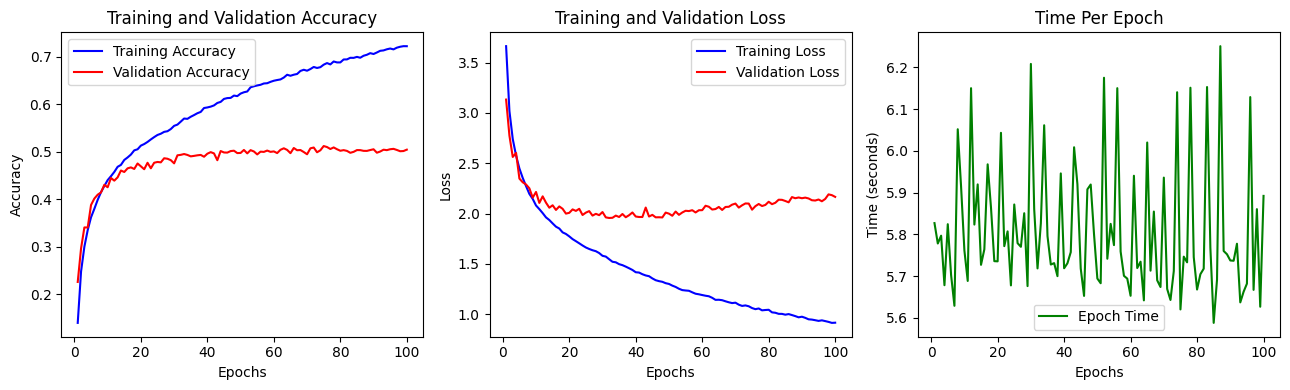

In [50]:
plot_train_and_val_accuracies_losses(train_accuracies, train_losses, val_accuracies, val_losses, epoch_times)

### Results Summary: GeneralizedCNN

The GeneralizedCNN model, updated to reduce overfitting, displays an encouraging trend across 100 training epochs. When comparing to the initial SimpleCNN model, it shows a narrower gap between training and validation accuracy, suggesting improved generalization. Specifically, the GeneralizedCNN achieved a higher validation accuracy of approximately 50% by the 100th epoch, an improvement over the SimpleCNN's plateau around 40%.

Loss graphs indicate a consistent reduction in training loss and a more stable validation loss, implying that the implemented strategies, including dropout and batch normalization, effectively mitigate overfitting.

Training times per epoch remained comparable to the SimpleCNN, despite the added complexity, averaging around 5.8 seconds. This consistency indicates that the model's generalization improvements did not come at the cost of significantly increased computational demands. 

Overall, the GeneralizedCNN shows a more balanced performance with better alignment between training and validation results, making it a more robust model for the CIFAR-100 dataset.

### Enhancing Dataset Robustness with Augmentation

To bolster the GeneralizedCNN's ability to generalize and further diminish overfitting, we have introduced a series of data augmentation techniques to the image preprocessing pipeline. The transformation sequence includes:

- **Random Horizontal Flip**: This increases the diversity of the training data by mirroring images, simulating the variance in real-world scenarios.
- **Random Rotation**: Images are rotated by up to 10 degrees, helping the model to learn orientation-invariant features.
- **Color Jitter**: This modification randomly alters brightness, contrast, and saturation of images, which can make the model more robust to lighting variations.
- **ToTensor and Normalize**: These standard steps convert image data into a tensor and normalize pixel values, facilitating model convergence during training.

By applying these transformations, each image in the dataset effectively generates a range of variations, expanding the dataset's effective size and complexity without collecting new data. This method is expected to enhance the model's predictive performance on unseen data by simulating a more comprehensive range of inputs during training.

In [11]:
def get_transformed_dataloaders(transform):
    fullset = torchvision.datasets.CIFAR100(root='./', train=True,
                                        download=True, transform=transform)

    # Get the indices of all data points
    indices = list(range(len(fullset)))

    # Split indices into training and validation sets
    train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42, stratify=[fullset.targets[i] for i in indices])

    train_subset = Subset(fullset, train_indices)
    val_subset = Subset(fullset, val_indices)

    trainloader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=4)
    valloader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=4)
    
    return trainloader, valloader

In [12]:
# Transform the data to tensor and normalize it
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainloader_transformed, valloader_transformed = get_transformed_dataloaders(transform)

Files already downloaded and verified


In [56]:
# Generalized CNN Model, Loss, and Optimizer
model = GeneralizedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_accuracies, train_losses, val_accuracies, val_losses, epoch_times = train(model, trainloader_transformed, valloader_transformed, criterion, optimizer, epochs=100)

Epoch 1: Duration: 9.72s, Train Loss: 3.7154, Train Accuracy: 0.1285, Validation Loss: 3.2812, Validation Accuracy: 0.1963
Epoch 2: Duration: 9.79s, Train Loss: 3.1518, Train Accuracy: 0.2230, Validation Loss: 2.9595, Validation Accuracy: 0.2659
Epoch 3: Duration: 9.89s, Train Loss: 2.9138, Train Accuracy: 0.2682, Validation Loss: 2.8005, Validation Accuracy: 0.2980
Epoch 4: Duration: 10.09s, Train Loss: 2.7598, Train Accuracy: 0.3003, Validation Loss: 2.6620, Validation Accuracy: 0.3278
Epoch 5: Duration: 9.91s, Train Loss: 2.6508, Train Accuracy: 0.3211, Validation Loss: 2.5035, Validation Accuracy: 0.3590
Epoch 6: Duration: 9.87s, Train Loss: 2.5630, Train Accuracy: 0.3383, Validation Loss: 2.5450, Validation Accuracy: 0.3535
Epoch 7: Duration: 10.01s, Train Loss: 2.4849, Train Accuracy: 0.3553, Validation Loss: 2.4396, Validation Accuracy: 0.3744
Epoch 8: Duration: 9.88s, Train Loss: 2.4195, Train Accuracy: 0.3673, Validation Loss: 2.3543, Validation Accuracy: 0.3932
Epoch 9: Durat

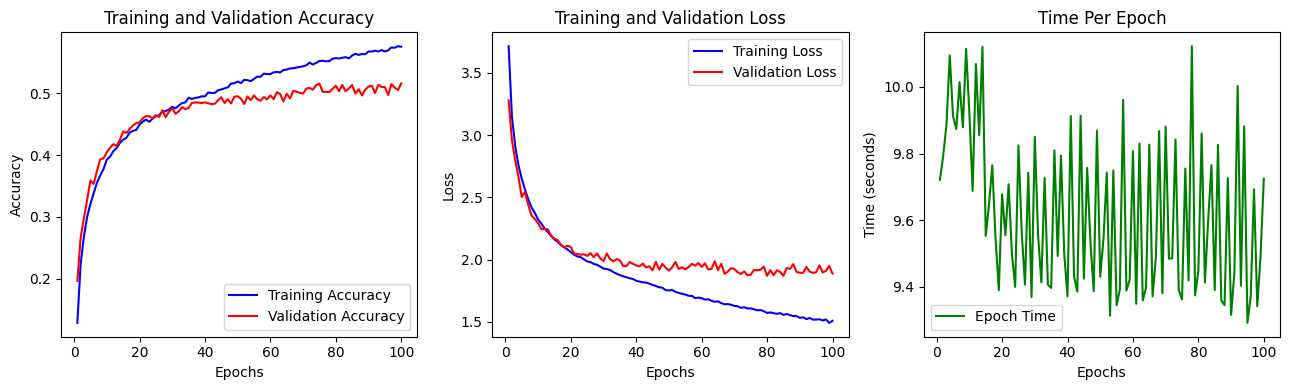

In [58]:
plot_train_and_val_accuracies_losses(train_accuracies, train_losses, val_accuracies, val_losses, epoch_times)

### Results Summary: Data Augmentation

The introduction of image transformations has led to a more generalized model, as evidenced by the closer alignment of training and validation accuracy in the results. These transformations have helped reduce overfitting significantly, as the validation accuracy increased and maintained consistency with the training accuracy, peaking at 51.59%.

Notably, the epoch times have increased, reflecting the additional computational overhead from the more complex image preprocessing. However, the benefits of improved model generalization outweigh the longer training time.

Overall, the use of augmented and transformed images appears to have enhanced the model's ability to learn from a more varied representation of the dataset, resulting in a more robust performance on the validation data.

### Hyperparameter Tuning of the GeneralizedCNN Model

#### Objective
To optimize the GeneralizedCNN model's performance, particularly with the augmented dataset, we employed hyperparameter tuning using the Optuna framework. Optuna is a hyperparameter optimization framework that automates the process of choosing the best hyperparameters for a learning algorithm.

#### Tuning Process
The objective function was defined to guide the optimization process. For each trial, Optuna suggested hyperparameters within specified ranges:

- **Number of Output Channels**: For each convolutional layer, the number of output channels was chosen from a categorical set [16, 32, 64], [32, 64, 128], and [64, 128, 256], respectively.
- **Fully Connected Layer Output Features**: The number of output features for the dense layer was selected from [256, 512, 1024].
- **Dropout Rates**: Dropout rates for the two dropout layers were suggested between 0.1 and 0.5.

The model was trained for 20 epochs for each trial with the given set of hyperparameters. The Adam optimizer was used with a learning rate of 0.001, and cross-entropy loss was employed as the loss criterion.

During training, both training and validation metrics were recorded, updating the progress bar with the latest accuracies and losses for real-time monitoring.

#### Evaluation Metric
The validation accuracy served as the primary metric for the Optuna study. This metric was returned at the end of each trial, allowing Optuna to identify the set of hyperparameters that maximized the validation accuracy.

#### Study Optimization
The Optuna study was directed to 'maximize' the objective metric, in this case, the validation accuracy. The study was executed for 30 trials, seeking the hyperparameter set that yields the best model generalization on the validation set.

Hyperparameter tuning is a crucial step to extract the best performance from a model. By leveraging Optuna's automated and efficient search capabilities, we aimed to identify the optimal model architecture and parameters that resonate well with the transformed and augmented dataset, leading to enhanced model performance and reduced overfitting. The final output from Optuna provides a set of hyperparameters that are expected to achieve the highest validation accuracy, balancing the model's capacity and its ability to generalize.

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):
    # Define hyperparameters using trial object
    conv1_output_channels = trial.suggest_categorical('conv1_output_channels', [16, 32, 64])
    conv2_output_channels = trial.suggest_categorical('conv2_output_channels', [32, 64, 128])
    conv3_output_channels = trial.suggest_categorical('conv3_output_channels', [64, 128, 256])
    fc1_output_features = trial.suggest_categorical('fc1_output_features', [256, 512, 1024])
    dropout1_rate = trial.suggest_float('dropout1_rate', 0.1, 0.5)
    dropout2_rate = trial.suggest_float('dropout2_rate', 0.1, 0.5)
    epochs = 20

    model = GeneralizedCNN(
        conv1_output_channels=conv1_output_channels,
        conv2_output_channels=conv2_output_channels,
        conv3_output_channels=conv3_output_channels,
        fc1_output_features=fc1_output_features,
        dropout1_rate=dropout1_rate,
        dropout2_rate=dropout2_rate
    ).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_accuracies, train_losses, val_accuracies, val_losses = [], [], [], []

    with tqdm(total=epochs, desc="Training Epochs") as pbar:
        for epoch in range(epochs):
            model.train()  # Set the model to training mode
            total_train_loss = 0
            total_correct = 0
            total = 0

            for images, labels in trainloader_transformed:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == labels).sum().item()
                total += labels.size(0)

            train_accuracy = total_correct / total
            avg_train_loss = total_train_loss / len(trainloader_transformed)

            # Validation step
            avg_val_loss, val_accuracy = validate(model, valloader_transformed, criterion)
            
            # Update progress bar description with latest metrics
            pbar.set_description(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
            pbar.update()

    return val_accuracy  # or another metric

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-04-16 00:39:24,810] A new study created in memory with name: no-name-4f72ad27-333f-41a9-b65a-576fb89f7822
Epoch 20/20 - Train Loss: 2.3041, Train Acc: 0.3936, Val Loss: 2.3726, Val Acc: 0.3920: 100%|██████████| 20/20 [04:49<00:00, 14.49s/it]
[I 2024-04-16 00:44:14,746] Trial 0 finished with value: 0.392 and parameters: {'conv1_output_channels': 64, 'conv2_output_channels': 32, 'conv3_output_channels': 128, 'fc1_output_features': 1024, 'dropout1_rate': 0.4847805499325064, 'dropout2_rate': 0.31621868092582617}. Best is trial 0 with value: 0.392.
Epoch 20/20 - Train Loss: 2.2212, Train Acc: 0.4121, Val Loss: 2.6651, Val Acc: 0.3538: 100%|██████████| 20/20 [04:46<00:00, 14.33s/it]
[I 2024-04-16 00:49:01,274] Trial 1 finished with value: 0.3538 and parameters: {'conv1_output_channels': 16, 'conv2_output_channels': 128, 'conv3_output_channels': 64, 'fc1_output_features': 512, 'dropout1_rate': 0.3284681067408278, 'dropout2_rate': 0.4680784182261333}. Best is trial 0 with value: 0.392.

In [3]:
def save_best_parameters(filename='best_parameters.json'):
    best_params = study.best_params  # Get the best parameters
    with open(filename, 'w') as f:
        json.dump(best_params, f, indent=4)

# Example: Assuming `study` is your Optuna study object
save_best_parameters()

In [13]:
# Generalized CNN Model, Loss, and Optimizer
model = GeneralizedCNN(**study.best_params)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_accuracies, train_losses, val_accuracies, val_losses, epoch_times = train(model, trainloader_transformed, valloader_transformed, criterion, optimizer, epochs=100)

Epoch 1: Duration: 11.77s, Train Loss: 3.6774, Train Accuracy: 0.1384, Validation Loss: 3.2683, Validation Accuracy: 0.2037
Epoch 2: Duration: 10.51s, Train Loss: 2.9632, Train Accuracy: 0.2567, Validation Loss: 2.8253, Validation Accuracy: 0.2868
Epoch 3: Duration: 10.61s, Train Loss: 2.6454, Train Accuracy: 0.3191, Validation Loss: 2.5628, Validation Accuracy: 0.3337
Epoch 4: Duration: 10.51s, Train Loss: 2.4556, Train Accuracy: 0.3619, Validation Loss: 2.4889, Validation Accuracy: 0.3514
Epoch 5: Duration: 10.52s, Train Loss: 2.3240, Train Accuracy: 0.3872, Validation Loss: 2.3554, Validation Accuracy: 0.3907
Epoch 6: Duration: 11.03s, Train Loss: 2.2033, Train Accuracy: 0.4152, Validation Loss: 2.2538, Validation Accuracy: 0.4059
Epoch 7: Duration: 10.54s, Train Loss: 2.1082, Train Accuracy: 0.4335, Validation Loss: 2.1800, Validation Accuracy: 0.4317
Epoch 8: Duration: 11.13s, Train Loss: 2.0309, Train Accuracy: 0.4527, Validation Loss: 2.1419, Validation Accuracy: 0.4338
Epoch 9:

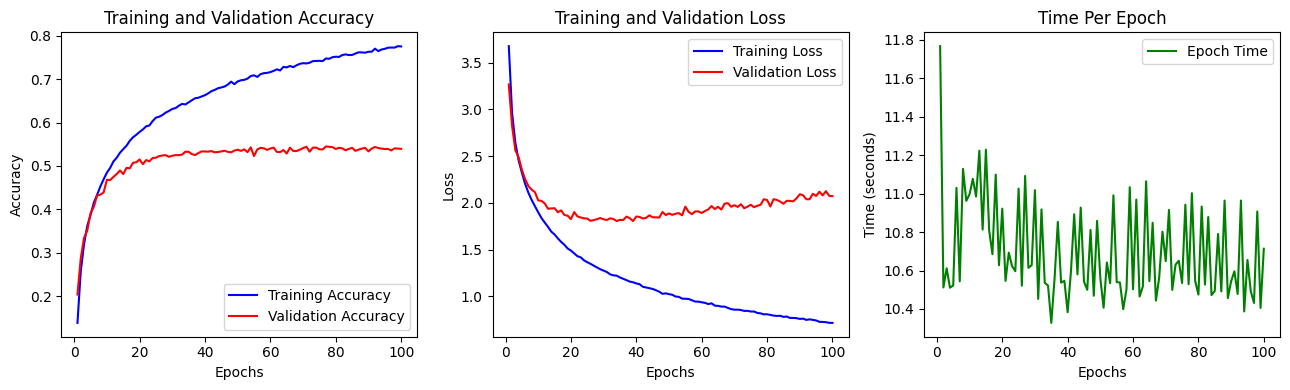

In [25]:
plot_train_and_val_accuracies_losses(train_accuracies, train_losses, val_accuracies, val_losses, epoch_times)

In [26]:
def get_all_preds_labels(model, loader):
    model.to(device)
    all_preds = []
    all_labels = []
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data, labels in loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())  # Move to CPU and convert to numpy
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

def plot_confusion_matrix(all_labels, all_preds, classes):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(24,24))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix', size=15)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes, rotation=0)
    plt.show()

Files already downloaded and verified


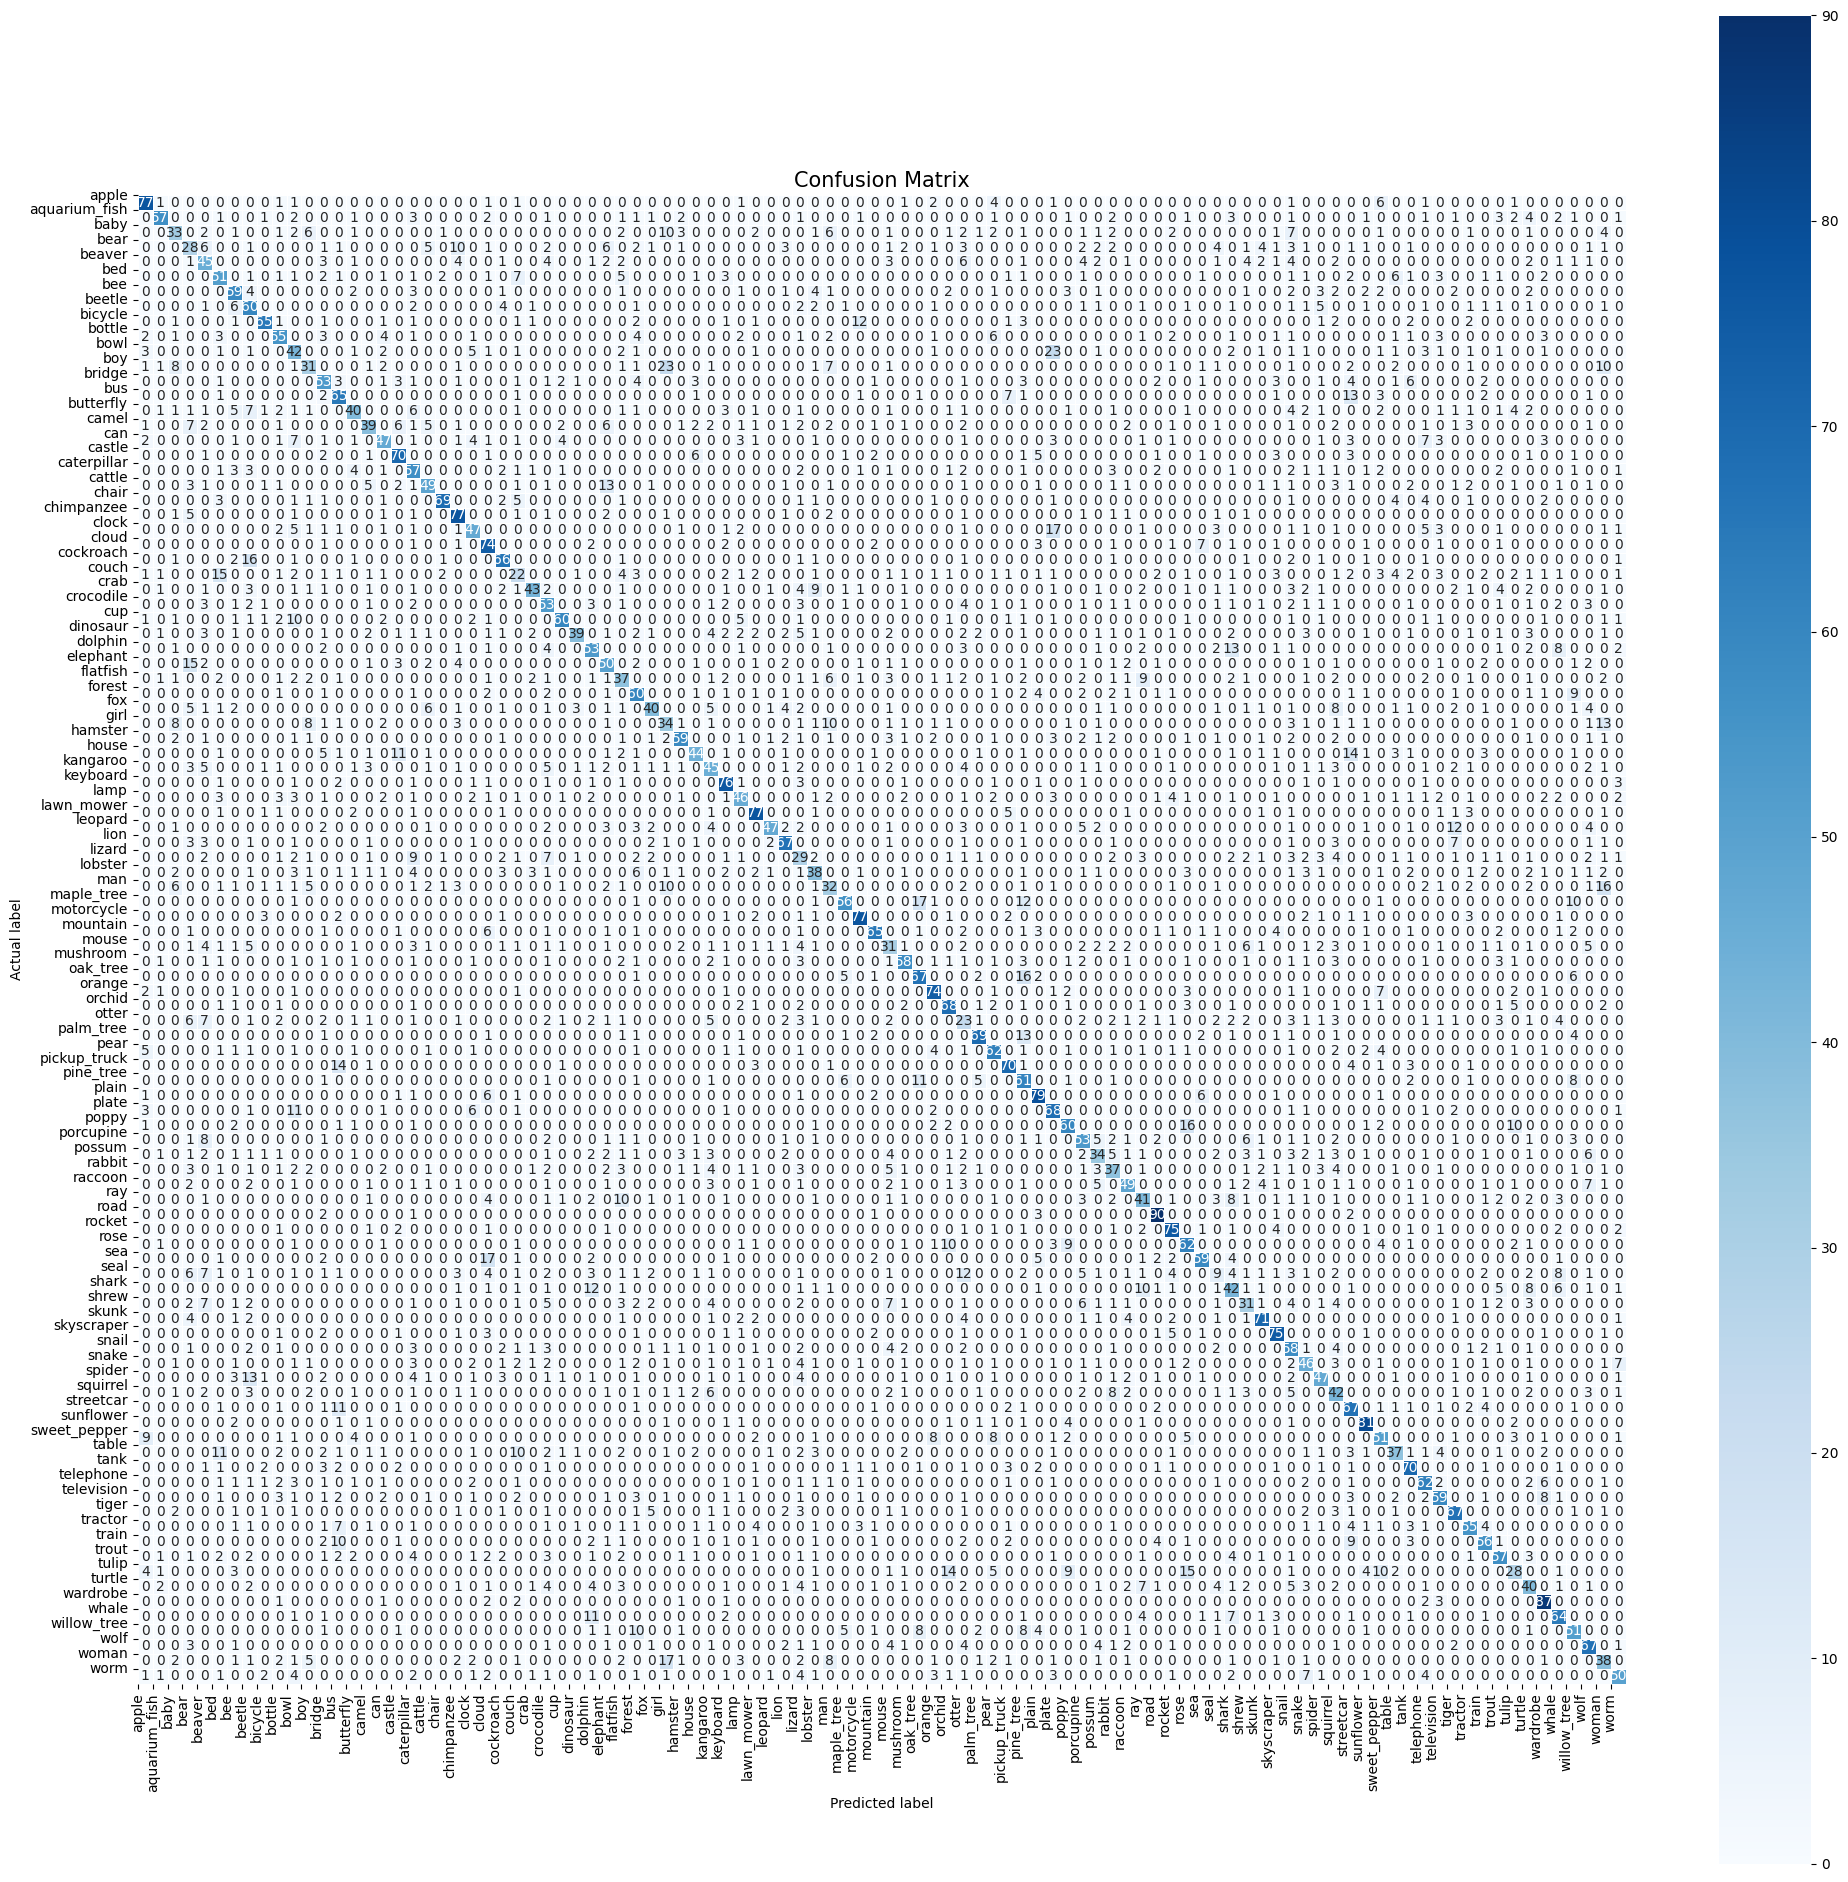

In [27]:
# Get all predictions and labels
all_preds, all_labels = get_all_preds_labels(model, valloader_transformed)

# Plot the confusion matrix
plot_confusion_matrix(all_labels, all_preds, classes)

### Conclusion: CIFAR-100 Dataset CNN Image Classification Project

#### Project Summary
This project embarked on the ambitious goal of classifying images from the CIFAR-100 dataset using convolutional neural networks (CNNs). We began with the construction of a SimpleCNN, a basic model built from scratch, which served as our baseline. To enhance performance, we leveraged a pretrained ResNet model, utilizing transfer learning to capitalize on pre-established hierarchies of image features.

#### Model Evolution
The SimpleCNN underwent iterative refinement to evolve into a more sophisticated GeneralizedCNN. This progression included the integration of dropout layers and batch normalization, which increased the model's resilience to overfitting and improved its ability to generalize from the training data to unseen validation data.

#### Data Augmentation
Recognizing the importance of a diverse training set, we augmented the dataset using color jitter, random rotation, and random horizontal flips. These transformations enriched the dataset, simulating a broader spectrum of real-world scenarios and further promoting model robustness.

#### Hyperparameter Tuning
Optuna, an optimization framework, was utilized to fine-tune the hyperparameters of the GeneralizedCNN. Through systematic experimentation over 30 trials, we identified optimal values that maximized validation accuracy.

#### Final Results
Each iteration of model development brought incremental improvements:

- The SimpleCNN achieved a validation accuracy of 40.03%.
- The pretrained ResNet model outperformed the basic SimpleCNN with an accuracy of 57.43%.
- The augmented GeneralizedCNN showed further improvement, reaching a validation accuracy of 51.59%.
- The hyperparameter-tuned GeneralizedCNN with augmented data achieved the highest accuracy of 53.94%.

The attached confusion matrix for the tuned GeneralizedCNN displays a promising diagonal concentration of predictions, indicating correct classifications, with some spread representing misclassifications.

#### Model Comparisons: Pros and Cons
The hyperparameter-tuned GeneralizedCNN with augmented data demonstrated a commendable balance of training efficiency and accuracy, although it did not outperform the ResNet model's accuracy. Despite being slower to train, the ResNet model's higher accuracy showcases the efficacy of transfer learning for complex tasks. The ResNet model benefits from a more in-depth architectural design and a pre-training process that captures a wide range of feature representations, which may account for its superior performance.

#### Recommendations for Improvement
To further enhance accuracy, we might consider ensembling models, where predictions from various models are combined. Additionally, continued hyperparameter optimization with extended searches or more advanced techniques, such as Bayesian optimization, could yield better performance. Investigating more complex augmentation techniques and exploring different pretrained models may also provide pathways to enhanced model robustness and accuracy.

#### Future Work
Future work can extend to testing the models on real-world data and deploying them in a production environment. It is also crucial to explore the impact of recent developments in CNN architectures and training techniques, including the use of more complex models and regularization methods. As the field of deep learning is rapidly evolving, staying abreast of new research could present opportunities to significantly advance the capabilities of our image classification models.